In [1]:
import seaborn as sns, pandas as pd, numpy as np
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, cross_validate, ParameterGrid, GridSearchCV, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, accuracy_score, precision_recall_fscore_support, classification_report, roc_auc_score, precision_recall_curve, auc, make_scorer
import plotly.express as px
import shap
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

data = pd.read_csv('./results/features_df.csv')
data

,Corpus,Type,Avg Word Length,Avg Sentence Length,TTR,MATTR,MTLD,Morpheme TTR,Avg Segs Per Word,Avg Forms Per Stem,Char Dist Entr,Word Dist Entr,Text Entr,Lex Entr,Rev Lex Entr
0,eo,con,5.175,18.909,10.708,0.692,67.482,7.535,1.859,3.506,4.164,10.923,4.435,6.303,7.016
1,nl,nat,5.419,18.194,8.559,0.694,74.165,12.467,1.809,3.044,4.117,10.593,4.389,6.407,6.746
2,is,nat,5.375,15.055,11.727,0.747,115.342,9.847,1.931,4.128,4.468,11.512,5.455,5.993,6.376
3,pl,nat,6.248,14.951,14.890,0.825,278.888,6.639,1.894,3.709,4.553,12.905,5.072,5.611,5.898
4,fr,nat,5.160,23.120,7.461,0.721,91.865,7.109,1.771,2.759,4.179,10.711,4.104,6.256,6.779
5,vo,con,5.072,11.266,2.455,0.622,39.447,15.287,1.567,1.938,4.256,7.666,1.281,8.702,9.037
6,af,nat,5.067,20.496,6.987,0.645,59.938,13.894,1.770,2.861,4.072,9.993,4.757,6.639,6.986
7,vi,nat,3.498,29.835,1.749,0.732,94.751,27.439,1.344,1.453,4.855,9.717,4.768,11.878,11.432
8,oc,nat,5.215,18.660,7.185,0.715,87.187,7.674,1.793,2.805,4.173,10.546,3.530,6.741,7.118
9,en,nat,5.087,21.301,6.079,0.697,77.659,10.049,1.661,2.360,4.167,10.673,4.771,7.106,7.601


### One Class SVM

Unnamed: 0       12179
kernel            poly
degree               3
coef0              0.3
gamma           0.0001
nu                 0.5
precision          1.0
recall        0.666667
f1                 0.8
Name: 12179, dtype: object
{'eo': (-1, 1), 'nl': (1, 1), 'is': (1, 1), 'pl': (1, 1), 'fr': (1, 1), 'vo': (-1, -1), 'af': (1, 1), 'vi': (1, 1), 'oc': (1, 1), 'en': (1, 1), 'it': (1, 1), 'ia': (-1, 1), 'sv': (1, 1), 'lfn': (-1, -1), 'da': (1, 1), 'hu': (1, 1), 'id': (1, 1), 'tl': (1, 1), 'tr': (1, 1), 'io': (-1, -1), 'es': (1, 1), 'fi': (1, 1), 'de': (1, 1), 'avk': (-1, -1)}


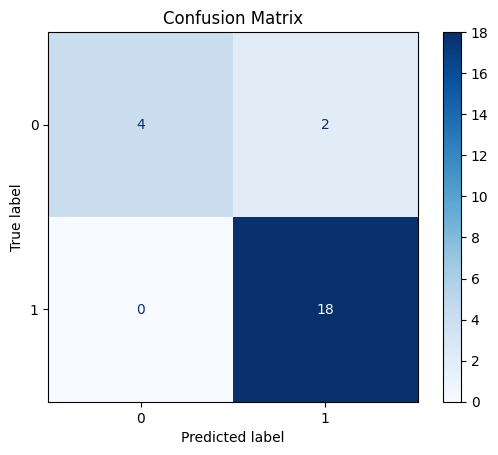

0.3238744148875717


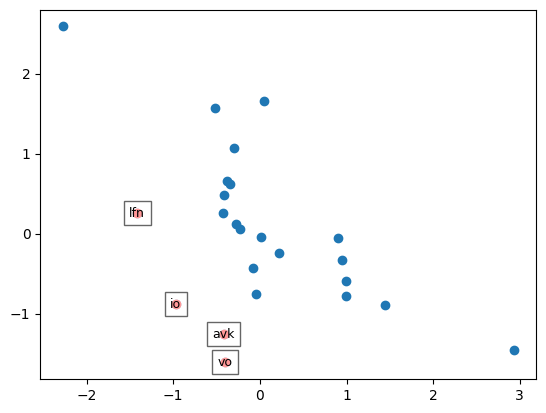

In [42]:
# OCSVM Finetuning
# Brute force approach (ParameterGrid)
# gamma defines how much influence a single training sample has. Smaller value means a larger radius of influence for each sample, and vice versa
# usually between γ∈[10^−6,10^0] used for the RBF kernel; common initial guesses around γ∈[0.001,1]
# nu is the upper bound on the fraction of training errors and a lower bound of support vectors. Controls proportion of outliers allowed
# usually between 0 and 1; common initial ranges around ν∈[0.01,0.5]

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
# Train on target == 'nat' (natural languages)
X_train = scaler.fit_transform(X)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [0, 1, 2, 3, 5, 10],
    'coef0': [0.0, 0.001, 0.002, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 1.0],
    'gamma': ['scale', 'auto', 0.000001, 0.0001, 0.001, 0.01, 0.1, 1],
    'nu': [0.01, 0.05, 0.1, 0.2, 0.25, 0.5]
}

grid = ParameterGrid(param_grid=param_grid)
results = []
# for params in grid:
#     ocsvm = OneClassSVM(
#         kernel=params['kernel'], 
#         degree=params['degree'], 
#         coef0=params['coef0'], 
#         gamma=params['gamma'], 
#         nu=params['nu'],
#         )
#     y_pred = ocsvm.fit_predict(X_train)
#     precision = precision_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     recall = recall_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     f1 = f1_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     # ap = average_precision_score(y, y_pred, pos_label=-1)
#     # roc_auc = roc_auc_score(y, ocsvm.decision_function(X_train))
    
#     results.append({
#         'kernel': params['kernel'],
#         'degree': params['degree'],
#         'coef0': params['coef0'],
#         'gamma': params['gamma'],
#         'nu': params['nu'],
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         # 'average_precision': ap,
#         # 'roc_auc': roc_auc,
#     })
    
# ocsvm_finetuning_df = pd.DataFrame(results)
# ocsvm_finetuning_df.to_csv('./results/ocsvm_finetuning_df.csv')
ocsvm_finetuning_df = pd.read_csv('./results/ocsvm_finetuning_df.csv')
# Best parameters based on f1 score
best_params = ocsvm_finetuning_df.sort_values(by='f1', ascending=False).iloc[0]
print(best_params)

# Evaluating fine-tuned model
ocsvm = OneClassSVM(
    kernel=best_params['kernel'],
    degree=best_params['degree'],
    coef0=best_params['coef0'],
    gamma=float(best_params['gamma']),
    nu=best_params['nu'],
)

ocsvm.fit(X_train)
y_pred = ocsvm.predict(X_train)
print({n: (y, y_pred) for n, (y, y_pred) in zip(data['Corpus'].values, zip(y, y_pred))})
# decision_scores = ocsvm.decision_function(X_train)
# # roc_auc = roc_auc_score(y, decision_scores)
# # print(f"ROC AUC: {roc_auc}")

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('./results/CM_ocsvm.png')
plt.show()

scores = ocsvm.score_samples(X_train)
thresh = np.quantile(scores, 0.15)
print(thresh)
index = np.where(scores<=thresh)
values = X_train[index]

# Labels
for i, corpus_value in enumerate(data['Corpus'].values):
    if y_pred[i] == -1: 
        plt.annotate(
            corpus_value, 
            (X_train[i, 0], X_train[i, 1]), 
            textcoords="offset points", xytext=(0, 0), 
            ha='center', va='center',  
            fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6)  
        )
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()

#### Fine-tuned OCSVM ('poly' kernel) with Decision Boundary and dimensionality reduction (PCA)

Unnamed: 0       10691
kernel            poly
degree               1
coef0              0.1
gamma             0.01
nu                 0.5
precision     0.714286
recall        0.833333
f1            0.769231
Name: 10691, dtype: object


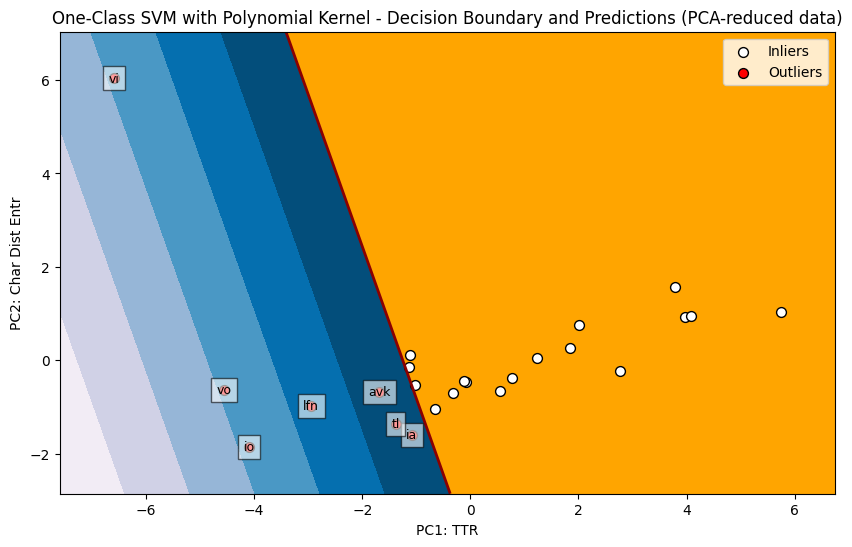

In [35]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_scaled)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [0, 1, 2, 3, 5, 10],
    'coef0': [0.0, 0.001, 0.002, 0.005, 0.007, 0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 1.0],
    'gamma': ['scale', 'auto', 0.000001, 0.0001, 0.001, 0.01, 0.1, 1],
    'nu': [0.01, 0.05, 0.1, 0.2, 0.25, 0.5]
}

grid = ParameterGrid(param_grid=param_grid)
results = []
# for params in grid:
#     ocsvm = OneClassSVM(
#         kernel=params['kernel'], 
#         degree=params['degree'], 
#         coef0=params['coef0'], 
#         gamma=params['gamma'], 
#         nu=params['nu'],
#         )
#     y_pred = ocsvm.fit_predict(X_train)
#     precision = precision_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     recall = recall_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     f1 = f1_score(y, y_pred, pos_label=-1, zero_division=0.0)
    
#     results.append({
#         'kernel': params['kernel'],
#         'degree': params['degree'],scoreafdddfaafafaf
#         'coef0': params['coef0'],
#         'gamma': params['gamma'],
#         'nu': params['nu'],
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     })
    
# ocsvm_pca_finetuning_df = pd.DataFrame(results)
# ocsvm_pca_finetuning_df.to_csv('./results/ocsvm_pca_finetuning_df.csv')

# Find PC1 and PC2
components_df = pd.DataFrame(pca.components_, columns=data.select_dtypes(include='number').columns, index=['PC1', 'PC2'])
def get_top_features(components_df, pc_name, top_n=1):
    pc_loadings = components_df.loc[pc_name]
    top_features = pc_loadings.abs().nlargest(top_n).index
    return top_features.tolist()

ocsvm_pca_finetuning_df = pd.read_csv('./results/ocsvm_pca_finetuning_df.csv')
best_params = ocsvm_pca_finetuning_df.sort_values(by='f1', ascending=False).iloc[0]
print(best_params)

ocsvm = OneClassSVM(
    kernel=best_params['kernel'],
    degree=best_params['degree'],
    coef0=best_params['coef0'],
    gamma=float(best_params['gamma']),
    nu=best_params['nu'],
)

ocsvm.fit(X_train)
y_pred = ocsvm.predict(X_train)

# Plotting
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 6))
# Decision boundary
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')
# Scatter plot of PCA-reduced training data
plt.scatter(X_train[y_pred == 1][:, 0], X_train[y_pred == 1][:, 1], c='white', edgecolors='k', s=50, label='Inliers')
plt.scatter(X_train[y_pred == -1][:, 0], X_train[y_pred == -1][:, 1], c='red', edgecolors='k', s=50, label='Outliers')
# Labels
for i, corpus_value in enumerate(data['Corpus'].values):
    if y_pred[i] == -1: 
        plt.annotate(
            corpus_value, 
            (X_train[i, 0], X_train[i, 1]), 
            textcoords="offset points", xytext=(0, 0), 
            ha='center', va='center',  
            fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6)  
        )
plt.title("One-Class SVM with Polynomial Kernel - Decision Boundary and Predictions (PCA-reduced data)")
plt.xlabel(f"PC1: {get_top_features(components_df, 'PC1')[0]}")
plt.ylabel(f"PC2: {get_top_features(components_df, 'PC2')[0]}")
plt.legend()
plt.show()

#### Fine-tuned OCSVM ('rbf' kernel) with Decision Boundary and dimension reductionality (PCA)

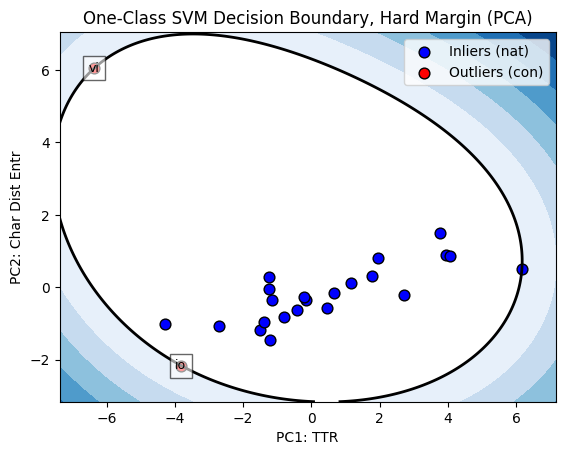

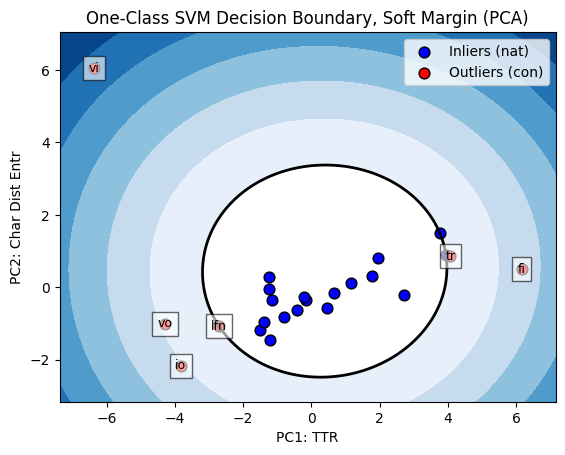

In [45]:
# Plot decision function of finetuned One-Class SVM (visualization in 2D space)
# How can I interpret the decision function? Should I visualize the decision boundary differently?

X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Find PC1 and PC2
components_df = pd.DataFrame(pca.components_, columns=data.select_dtypes(include='number').columns, index=['PC1', 'PC2'])
def get_top_features(components_df, pc_name, top_n=1):
    pc_loadings = components_df.loc[pc_name]
    top_features = pc_loadings.abs().nlargest(top_n).index
    return top_features.tolist()

# Hard Margin OCSVM
# Has 2 outliers at n=0.05
hard_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
hard_ocsvm.fit(X_pca)

# Predict the decision function (distance to the decision boundary)
hard_decision_function = hard_ocsvm.decision_function(X_pca)
hard_pred = hard_ocsvm.predict(X_pca)

# Plot decision boundary and margins
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500))

Z = hard_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision function as a contour plot
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='white')

plt.scatter(X_pca[hard_pred == 1][:, 0], X_pca[hard_pred == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(X_pca[hard_pred == -1][:, 0], X_pca[hard_pred == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

for i, corpus_value in enumerate(data['Corpus'].values):
    if hard_pred[i] == -1: 
        plt.annotate(
            corpus_value, 
            (X_pca[i, 0], X_pca[i, 1]), 
            textcoords="offset points", xytext=(0, 0), 
            ha='center', va='center',  
            fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6)  
        )

plt.title('One-Class SVM Decision Boundary, Hard Margin (PCA)')
plt.xlabel(f"PC1: {get_top_features(components_df, 'PC1')[0]}")
plt.ylabel(f"PC2: {get_top_features(components_df, 'PC2')[0]}")
plt.legend()
plt.savefig('./results/OCSVM_PCA_hard.png')
plt.show()

# Soft Margin OCSVM
# Has 8 outliers at n=0.3
soft_ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.3)
soft_ocsvm.fit(X_pca)

# Predict the decision function (distance to the decision boundary)
soft_decision_function = soft_ocsvm.decision_function(X_pca)
soft_pred = soft_ocsvm.predict(X_pca)

# Plot decision boundary and margins
xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 500),
                     np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 500))

Z = soft_ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision function as a contour plot
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='white')

plt.scatter(X_pca[soft_pred == 1][:, 0], X_pca[soft_pred == 1][:, 1], 
            c='blue', label='Inliers (nat)', edgecolors='k', s=60)
plt.scatter(X_pca[soft_pred == -1][:, 0], X_pca[soft_pred == -1][:, 1], 
            c='red', label='Outliers (con)', edgecolors='k', s=60)

for i, corpus_value in enumerate(data['Corpus'].values):
    if soft_pred[i] == -1: 
        plt.annotate(
            corpus_value, 
            (X_pca[i, 0], X_pca[i, 1]), 
            textcoords="offset points", xytext=(0, 0), 
            ha='center', va='center',  
            fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6)  
        )

plt.title('One-Class SVM Decision Boundary, Soft Margin (PCA)')
plt.xlabel(f"PC1: {get_top_features(components_df, 'PC1')[0]}")
plt.ylabel(f"PC2: {get_top_features(components_df, 'PC2')[0]}")
plt.legend()
plt.savefig('./results/OCSVM_PCA_soft.png')
plt.show()

### Isolation Forest

Unnamed: 0           3889
max_samples           0.5
contamination         0.2
n_estimators           10
max_features          1.0
bootstrap           False
precision             0.8
recall           0.666667
f1               0.727273
Name: 3889, dtype: object
{'eo': (-1, 1), 'nl': (1, 1), 'is': (1, 1), 'pl': (1, 1), 'fr': (1, 1), 'vo': (-1, -1), 'af': (1, 1), 'vi': (1, -1), 'oc': (1, 1), 'en': (1, 1), 'it': (1, 1), 'ia': (-1, 1), 'sv': (1, 1), 'lfn': (-1, -1), 'da': (1, 1), 'hu': (1, 1), 'id': (1, 1), 'tl': (1, 1), 'tr': (1, 1), 'io': (-1, -1), 'es': (1, 1), 'fi': (1, 1), 'de': (1, 1), 'avk': (-1, -1)}


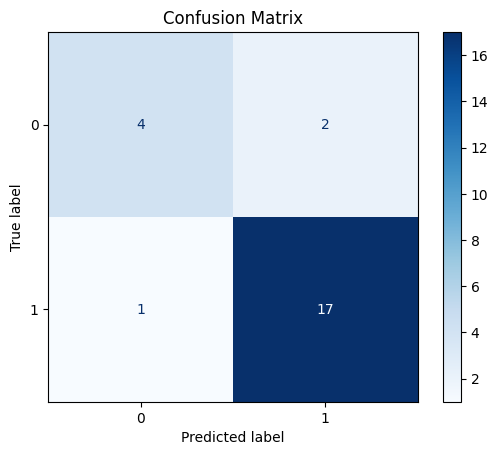

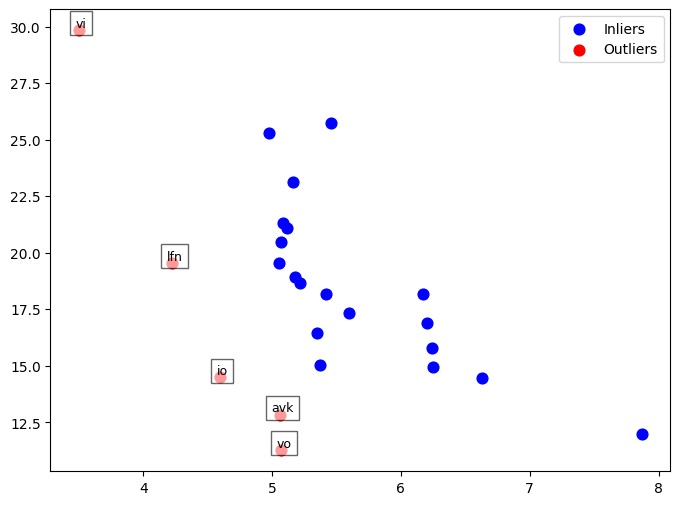

In [47]:
# Finetuning IF
X_train, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values

param_grid = {
    'max_samples': ['auto', 0.1, 0.3, 0.5, 0.7, 0.9, len(X_train)],
    'contamination': ['auto', 0.01, 0.03, 0.05, 0.1, 0.2, 0.25, 0.5],
    'n_estimators': [5, 10, 15, 20, 50, 100, 200, 300],
    'max_features': [0.1, 0.3, 0.5, 0.7, 1.0],
    'bootstrap': [True, False],
}

grid = ParameterGrid(param_grid=param_grid)
results = []
# for params in grid:
#     ifo = IsolationForest(
#         max_samples=params['max_samples'], 
#         contamination=params['contamination'], 
#         n_estimators=params['n_estimators'], 
#         max_features=params['max_features'], 
#         bootstrap=params['bootstrap'],
#         random_state=42, 
#         n_jobs=-1
#         )
#     y_pred = ifo.fit_predict(X_train)
#     precision = precision_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     recall = recall_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     f1 = f1_score(y, y_pred, pos_label=-1, zero_division=0.0)
    
#     results.append({
#         'max_samples': params['max_samples'],
#         'contamination': params['contamination'],
#         'n_estimators': params['n_estimators'],
#         'max_features': params['max_features'],
#         'bootstrap': params['bootstrap'],
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     })
    
# if_finetuning_df = pd.DataFrame(results)
# if_finetuning_df.to_csv('./results/if_finetuning_df.csv')
if_finetuning_df = pd.read_csv('./results/if_finetuning_df.csv')
# Best parameters based on f1 score
best_params = if_finetuning_df.sort_values(by='f1', ascending=False).iloc[0]
print(best_params)

# Evaluating fine-tuned model
ifo = IsolationForest(
    max_samples=float(best_params['max_samples']),
    contamination=float(best_params['contamination']),
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
    n_jobs=-1,
)

y_pred = ifo.fit_predict(X_train)
decision_scores = ifo.decision_function(X_train)
print({n: (y, y_pred) for n, (y, y_pred) in zip(data['Corpus'].values, zip(y, y_pred))})

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('./results/CM_if.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_pred == 1][:, 0], X_train[y_pred == 1][:, 1], label="Inliers", c='blue', s=60)
plt.scatter(X_train[y_pred == -1][:, 0], X_train[y_pred == -1][:, 1], label="Outliers", c='red', s=60)
for i, txt in enumerate(data['Corpus']):
    if y_pred[i] == -1: 
        plt.text(X_train[i, 0] + 0.02, X_train[i, 1] + 0.02, txt, fontsize=9, color='black',
                 ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6))
# plt.title("Isolation Forest Outliers")
plt.legend()
plt.savefig('./results/IF_outliers.png')
plt.show()

# disp = DecisionBoundaryDisplay.from_estimator(
#     ifo,
#     X_train,
#     response_method="predict",
#     alpha=0.5,
# )
# disp.ax_.scatter(X_train[:,0], X_train[:,1], c=y, s=20, edgecolor="k")
# disp.ax_.set_title("Binary Decision Boundary \nof Isolation Forest")
# plt.axis("square")
# plt.legend()
# plt.show()

#### Fine-tuned IF's feature importances with SHAP

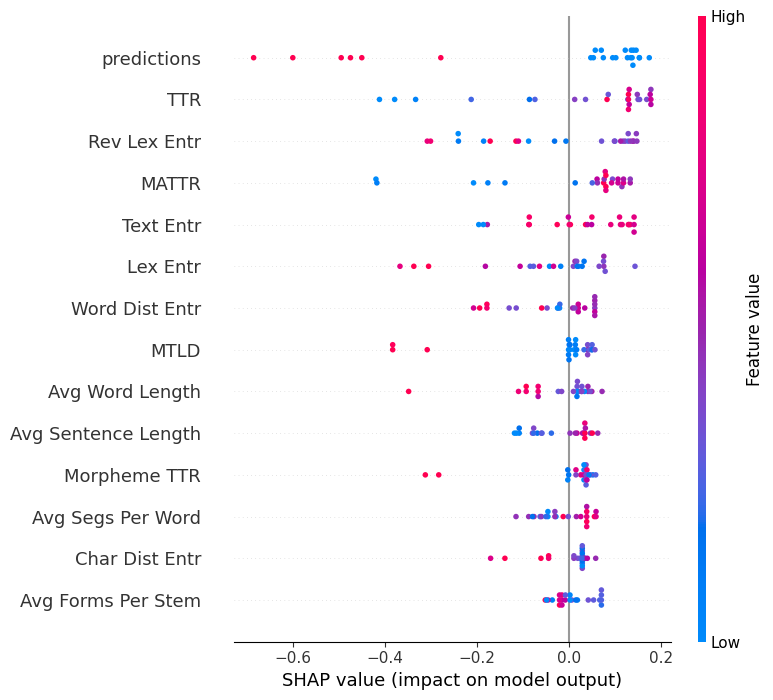

In [48]:
shap_values = shap.TreeExplainer(ifo).shap_values(X_train)
shap.summary_plot(shap_values, X_train, show=False, feature_names=data.iloc[:,2:].columns.values)
plt.savefig("./results/IF_SHAP_values.png")
plt.show()

# explainer = shap.Explainer(ifc)
# shap_values = explainer(X_train)
# shap.plots.waterfall(shap_values[0])

# def global_shap_importance(model, X):
#     """ Return a dataframe containing the features sorted by Shap importance
#     Parameters
#     ----------
#     model : The tree-based model 
#     X : pd.Dataframe
#          training set/test set/the whole dataset ... (without the label)
#     Returns
#     -------
#     pd.Dataframe
#         A dataframe containing the features sorted by Shap importance
#     """
#     explainer = shap.Explainer(model)
#     shap_values = explainer(X)
#     cohorts = {"": shap_values}
#     cohort_labels = list(cohorts.keys())
#     cohort_exps = list(cohorts.values())
#     for i in range(len(cohort_exps)):
#         if len(cohort_exps[i].shape) == 2:
#             cohort_exps[i] = cohort_exps[i].abs.mean(0)
#     features = cohort_exps[0].data
#     feature_names = cohort_exps[0].feature_names
#     values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
#     feature_importance = pd.DataFrame(
#         list(zip(feature_names, sum(values))), columns=['features', 'importance'])
#     feature_importance.sort_values(
#         by=['importance'], ascending=False, inplace=True)
#     return feature_importance

#### IF with PCA

In [49]:
n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(data.iloc[:,2:].values.round(decimals=3))

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Type'

fig = px.scatter_matrix(
    components,
    color=data['Type'],
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [50]:
score = ifo.decision_function(X_train)
score_df = pd.DataFrame(score, columns=['Decision Function Scores'])
data_scores = pd.concat([data['Corpus'], score_df], axis=1)
display(data_scores)

,Corpus,Decision Function Scores
0,eo,0.150235
1,nl,0.151677
2,is,0.122053
3,pl,0.024462
4,fr,0.148364
5,vo,-0.126502
6,af,0.135837
7,vi,-0.092493
8,oc,0.123770
9,en,0.089359


In [51]:
data['predictions'] = ifo.predict(X)
data['predictions'] = np.where(data['predictions']==-1,1,0)

n_components = 3
pca = PCA(n_components=n_components)
components = pca.fit_transform(data.iloc[:,2:].values.round(decimals=3))

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Type'

fig = px.scatter_matrix(
    components,
    color=data['predictions'],
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

### Local Outlier Factor

Best parameters: Unnamed: 0            3362
n_neighbors              5
algorithm            brute
leaf_size                5
metric           euclidean
contamination         0.25
precision         0.666667
recall            0.666667
f1                0.666667
Name: 3362, dtype: object
{'eo': (-1, 1), 'nl': (1, 1), 'is': (1, 1), 'pl': (1, 1), 'fr': (1, 1), 'vo': (-1, -1), 'af': (1, 1), 'vi': (1, -1), 'oc': (1, 1), 'en': (1, 1), 'it': (1, 1), 'ia': (-1, 1), 'sv': (1, 1), 'lfn': (-1, -1), 'da': (1, 1), 'hu': (1, 1), 'id': (1, 1), 'tl': (1, 1), 'tr': (1, 1), 'io': (-1, -1), 'es': (1, 1), 'fi': (1, -1), 'de': (1, 1), 'avk': (-1, -1)}


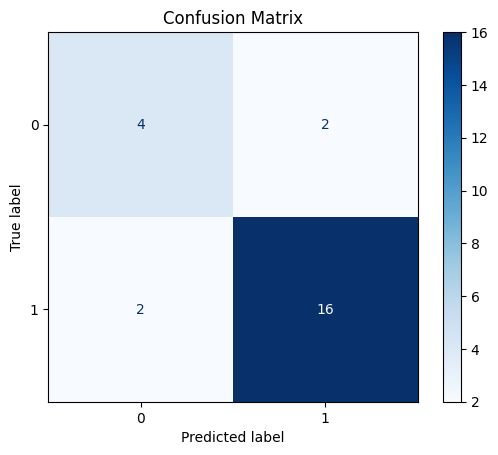

In [52]:
X, y = data.iloc[:,2:].values.round(decimals=3), data.iloc[:,1].map({'con':-1, 'nat':1}).values
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 12, 18],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [5, 10, 15, 30, 50, 100, 200, 300],
    'metric': ['euclidean', 'manhattan'],
    # 'p': [1, 2],
    'contamination': ['auto', 0.01, 0.03, 0.05, 0.1, 0.2, 0.25, 0.5],
}

grid = ParameterGrid(param_grid=param_grid)
results = []
# for params in grid:
#     lof = LocalOutlierFactor(
#         n_neighbors=params['n_neighbors'], 
#         algorithm=params['algorithm'], 
#         leaf_size=params['leaf_size'], 
#         metric=params['metric'],
#         # p=params['p'],
#         contamination=params['contamination'], 
#         n_jobs=-1,
#         )
#     y_pred = lof.fit_predict(X_train)
#     precision = precision_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     recall = recall_score(y, y_pred, pos_label=-1, zero_division=0.0)
#     f1 = f1_score(y, y_pred, pos_label=-1, zero_division=0.0)
    
#     results.append({
#         'n_neighbors': params['n_neighbors'],
#         'algorithm': params['algorithm'],
#         'leaf_size': params['leaf_size'],
#         'metric': params['metric'],
#         'contamination': params['contamination'],
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#     })
    
# lof_finetuning_df = pd.DataFrame(results)
# lof_finetuning_df.to_csv('./results/lof_finetuning_df.csv')
lof_finetuning_df = pd.read_csv('./results/lof_finetuning_df.csv')
# Best parameters based on f1 score
best_params = lof_finetuning_df.sort_values(by='f1', ascending=False).iloc[0]
print(f'Best parameters: {best_params}')

# Evaluating fine-tuned model
lof = LocalOutlierFactor(
    n_neighbors=best_params['n_neighbors'],
    algorithm=best_params['algorithm'],
    leaf_size=best_params['leaf_size'],
    metric=best_params['metric'],
    # p=best_params['p'],
    contamination=float(best_params['contamination']),
)

y_pred = lof.fit_predict(X_train)
print({n: (y, y_pred) for n, (y, y_pred) in zip(data['Corpus'].values, zip(y, y_pred))})
# decision_scores = lof.decision_function(X_train)

cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('./results/CM_lof.png')
plt.show()